In [6]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/Users/james/anaconda2/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['multivariate_normal']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [7]:
import seaborn as sns
sns.set()
import torch 
import torch.nn as nn
import torch.utils.data
from torch.autograd import Variable # storing data while learning
from torch import optim
from torch.utils import data as utilsdata
import torch.nn.functional as F
from torch.distributions import Categorical
from sklearn.model_selection import train_test_split
from scipy.stats import multivariate_normal
from scipy.signal import argrelmax
from tqdm import tqdm_notebook as tqdm
import scipy
import numpy as np
import os
import pandas as pd
import sys
from scipy.stats import pearsonr
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

In [8]:
cd /Users/james/signal

/Users/james/signal


In [9]:
sys.path.append('bin')

In [11]:
from utils import prepare_dataset, preprocess,preprocess_zscore, get_original_parameters, report_metrics, mdn_logp, mdn_loss
from model import MixtureDensityNetwork, IsotropicGaussianMixture
from find_best import visualize_report

### parrallel sbatch

#并行着处理ncomponents 从2到20 在rc上/n/coxfs01/xupeng/projects/signal
#!/bin/bash
# add all other SBATCH directives here...

#SBATCH -p cox
#SBATCH --gres=gpu:0
#SBATCH --constraint=titanx
#SBATCH -n 16  # Number of cores
#SBATCH -N 1 # Ensure that all cores are on one machine
#SBATCH --mem=50000
#SBATCH -t 2-00:00:00
#SBATCH -o logs/train_%j.log
#SBATCH -e logs/signal.err # STDERR

{
COUNTER=0
for dataname in whole rss aoa toa data_4 data_5 data_6
do
    for n_components in $(seq 2 2 20)
    do
        for batch in $(seq 5 5 20)
        do
            for early_epoch in $(seq 20 20 100)
            do
                for logsigmamin in $(seq -4 -1) 
                do
                    for logsigmamax in $(seq 0 3)
                    do
                        for nhidden1 in $(seq 20 2 30)
                        do
                            nhidden2=$[$nhidden1-2]
                            nhidden3=$[$nhidden1-4]
                            COUNTER=$[$COUNTER +1]
                            echo $dataname  $n_components  $batch  $early_epoch  $nhidden1  $nhidden2 $nhidden3  $logsigmamin  $logsigmamax
                            python bin/test_parameters.py --data $dataname --n_components $n_components --batch $batch --early_epoch $early_epoch --nhidden1 $nhidden1 --nhidden2 $nhidden2 --nhidden3 $nhidden3 --logsigmamin $logsigmamin --logsigmamax $logsigmamax
                        done
                    done
                done
            done
        done
    done
done
echo $COUNTER
} | parallel -P 16

In [12]:
rmsesss = np.loadtxt('rmses_.txt',dtype='str')[:,1].astype('float')

In [13]:
rmsesss_paraname = np.loadtxt('rmses_.txt',dtype='str')[:,0]

(array([631., 203., 262., 421., 227., 147., 124., 148., 293., 362., 294.,
        221., 216., 221., 189., 190., 178., 157., 195., 352., 331., 250.,
        264., 294., 296., 302., 229., 180., 124.,  94.,  64.,  48.,  41.,
         31.,  26.,  22.,  11.,   7.,  11.,  15.,  15.,  18.,  10.,   1.,
          8.,  21.,  23.,  14.,  11.,   6.]),
 array([ 164.83199138,  275.62105086,  386.41011035,  497.19916983,
         607.98822932,  718.7772888 ,  829.56634829,  940.35540777,
        1051.14446726, 1161.93352675, 1272.72258623, 1383.51164572,
        1494.3007052 , 1605.08976469, 1715.87882417, 1826.66788366,
        1937.45694314, 2048.24600263, 2159.03506212, 2269.8241216 ,
        2380.61318109, 2491.40224057, 2602.19130006, 2712.98035954,
        2823.76941903, 2934.55847851, 3045.347538  , 3156.13659749,
        3266.92565697, 3377.71471646, 3488.50377594, 3599.29283543,
        3710.08189491, 3820.8709544 , 3931.66001388, 4042.44907337,
        4153.23813286, 4264.02719234, 4374.816

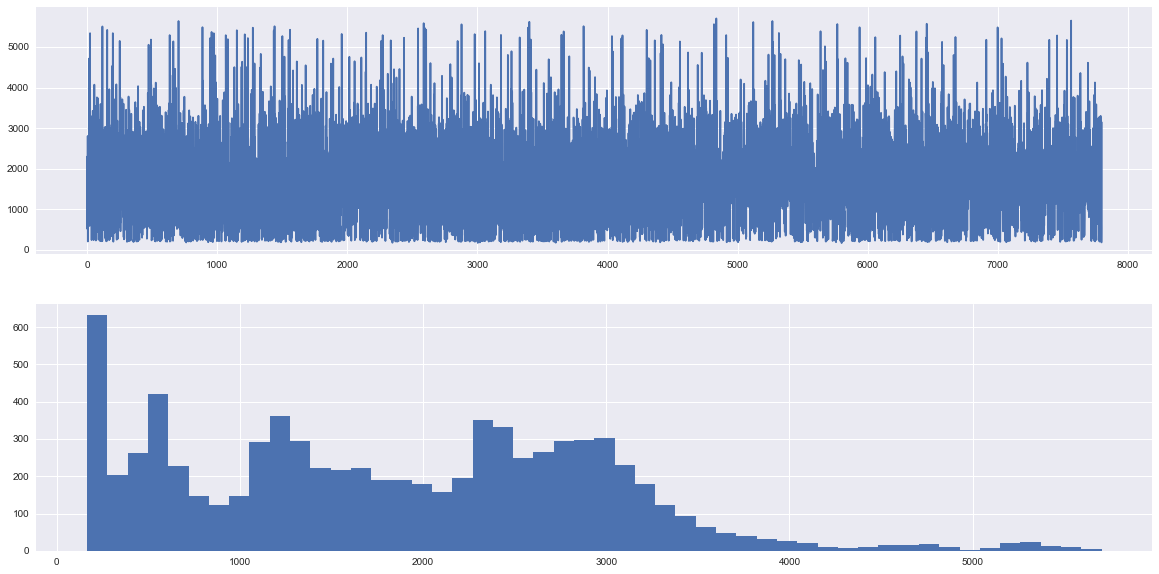

In [14]:
fig,ax=plt.subplots(2,figsize=(20,10))
ax[0].plot(rmsesss)
ax[1].hist(rmsesss.astype('float'),bins=50)

In [15]:
indunder200 = np.where(rmsesss <=200)[0]

In [16]:
#batch, ncomponents,datatype,earlyepoch,nhidden1,logsigmamin,logsigmamax
np.array(rmsesss_paraname[indunder200[0]].split('_'))[np.array([1,3,5,9,12,16,17])]

array(['5', '6', 'data', 'earlyepoch', '1', 'max', '-2'], dtype='|S10')

In [17]:
paras = np.ndarray([indunder200.shape[0],8]).astype('str')
for i in range(paras.shape[0]):
    paras[i][:7] = np.array(rmsesss_paraname[indunder200[i]].split('_'))[np.array([1,3,5,9,12,16,17])]
    paras[i][7] = np.round(rmsesss[indunder200[i]],2).astype('str')

In [18]:
paradata = pd.DataFrame(paras,columns=np.array(['batch','n_gaussian','data','earlystop','nhidden1','sigmamin','sigmamax','RMSE']))

In [19]:
paradata

,batch,n_gaussian,data,earlystop,nhidden1,sigmamin,sigmamax,RMSE
0,5,6,data,earlyepoch,1,max,-2,198.93
1,10,6,toa,20,30,-2,0,194.21
2,15,4,toa,40,26,-1,0,194.17
3,10,2,data,earlyepoch,1,max,-1,197.16
4,10,4,whole,40,26,-1,0,179.94
5,5,4,toa,20,26,-1,1,186.01
6,5,2,data,earlyepoch,1,max,-1,189.29
7,5,2,toa,20,26,-1,1,191.83
8,15,2,toa,20,22,-1,1,193.56
9,15,2,toa,40,26,-1,0,190.47


Text(0.5,1,u'RMSE distribution, total condistions: 7798')

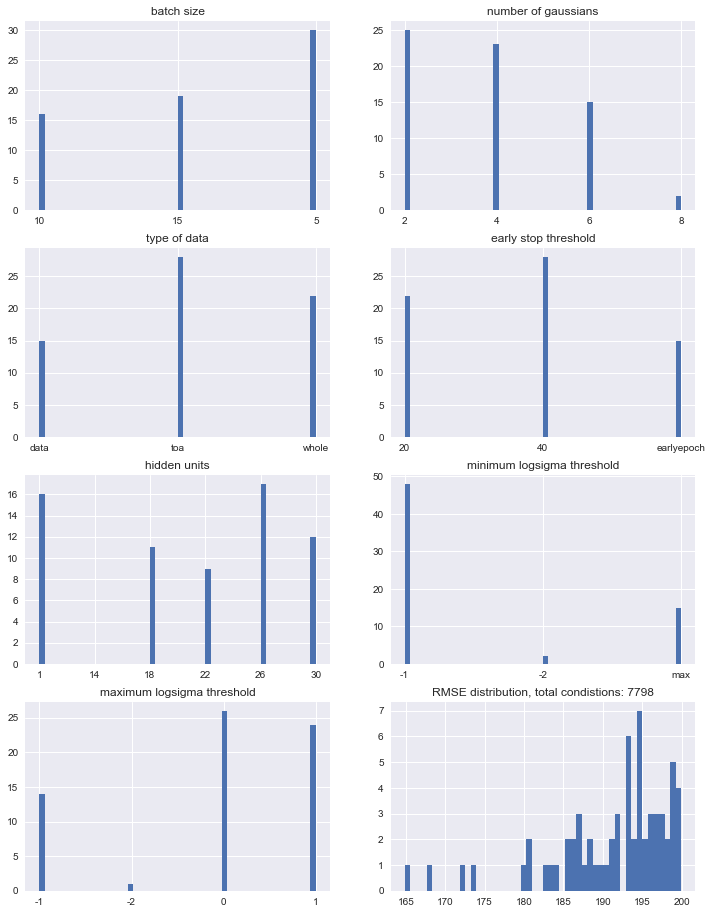

In [20]:
fig,ax=plt.subplots(4,2,figsize=(12,16))
ax[0,0].hist(paradata['batch'],bins=50)
ax[0,0].set_title('batch size')
ax[0,1].hist(paradata['n_gaussian'],bins=50)
ax[0,1].set_title('number of gaussians')
ax[1,0].hist(paradata['data'],bins=50)
ax[1,0].set_title('type of data')
ax[1,1].hist(paradata['earlystop'],bins=50)
ax[1,1].set_title('early stop threshold')
ax[2,0].hist(paradata['nhidden1'],bins=50)
ax[2,0].set_title('hidden units')
ax[2,1].hist(paradata['sigmamin'],bins=50)
ax[2,1].set_title('minimum logsigma threshold')
ax[3,0].hist(paradata['sigmamax'],bins=50)
ax[3,0].set_title('maximum logsigma threshold')
ax[3,1].hist(rmsesss[indunder200],bins=50)
ax[3,1].set_title('RMSE distribution, total condistions: '+str(rmsesss.shape[0]))

### find RMSE under 200 and save to 'bestparas_new/'
- already implemented in find_best.py

In [30]:
visual = visualize_report(50)

100%|██████████| 250/250 [00:00<00:00, 339.21it/s]


In [31]:
visual.report(True)

('RMSE, PCC: ', (344.18308600678137, (0.9688703324996065, 4.239285349743739e-304)))
('correlation of RMSE and probes: ', (0.9566950053897904, 6.352165128695804e-135))


In [32]:
visual.plot_distribution(True)

('p_modes', array([8.68163475]))
('p_modes', array([1.28005371e-23, 8.67269385e+00]))
('p_modes', array([1.32347362e-19, 8.67490387e+00]))
('p_modes', array([8.68170770e+00, 1.62333677e-15]))
('p_modes', array([4.16827598e-11, 8.67388882e+00]))
('p_modes', array([7.81834118e-11, 8.68130044e+00]))
('p_modes', array([8.18647194]))
('p_modes', array([8.67893316]))
('p_modes', array([8.67990157]))
('p_modes', array([8.67426496]))
('p_modes', array([8.67552443e+00, 1.05420762e-34]))
('p_modes', array([8.67301285e+00, 4.57540376e-32, 9.64874639e-03]))
('p_modes', array([4.32224059e-20, 8.66753999e+00]))
('p_modes', array([6.04312387e-21, 8.68188147e+00]))
('p_modes', array([9.46373570e-36, 8.67997966e+00]))
('p_modes', array([8.65503454]))


('RMSE, PCC: ', (344.18308600678137, (0.9688703324996065, 4.239285349743739e-304)))
('correlation of RMSE and probes: ', (0.9566950053897904, 6.352165128695804e-135))
((250,), (250,), (250,), (250,))


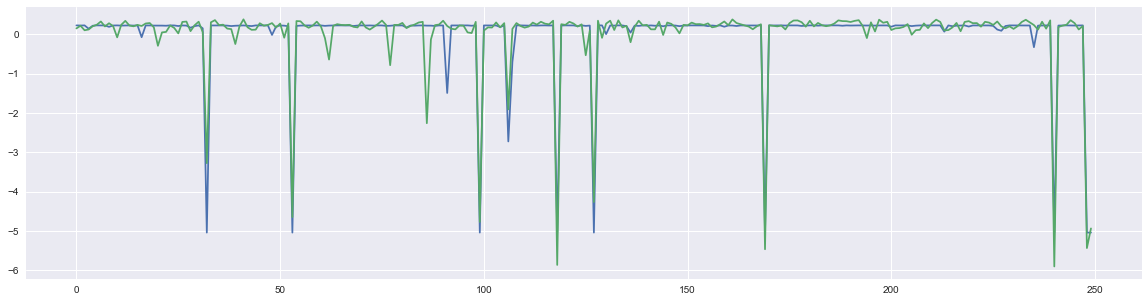

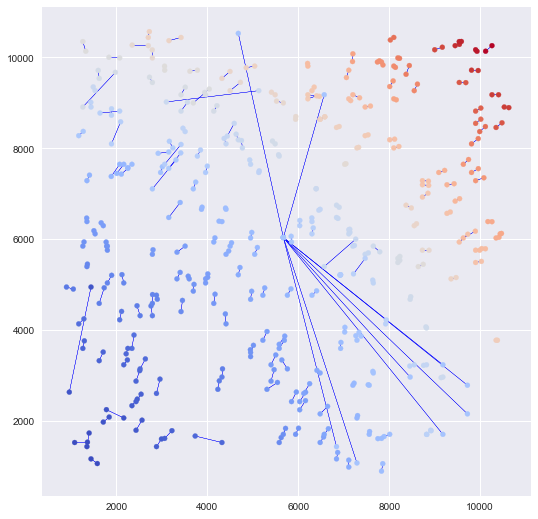

In [33]:
visual.report()
visual.plot_correlation()
visual.plot_arrows()

### check result under RMSE 200

In [34]:
from scipy.misc import imread
import matplotlib.pyplot as plt
import numpy as np
%pylab inline
import os
load_path = 'bestparas_new/'

Populating the interactive namespace from numpy and matplotlib


/Users/james/anaconda2/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['imread']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


('batch_15_gaussian_4_datatype_toa_batch_15_earlyepoch_20_nhidden_1_30_logsigma_min_max_-2_0', 0.9566950053897904)
('batch_10_gaussian_10_datatype_aoa_batch_10_earlyepoch_20_nhidden_1_18_logsigma_min_max_-3_1', 0.6088707338402423)
no such file
('batch_10_gaussian_6_datatype_toa_batch_10_earlyepoch_20_nhidden_1_30_logsigma_min_max_-2_0', 0.617308837953257)
no such file
('batch_5_gaussian_2_datatype_data_6_batch_5_earlyepoch_40_nhidden_1_18_logsigma_min_max_-1_1', 0.8795322629201218)
('batch_5_gaussian_2_datatype_data_6_batch_5_earlyepoch_40_nhidden_1_18_logsigma_min_max_-1_0', 0.5413455168654475)


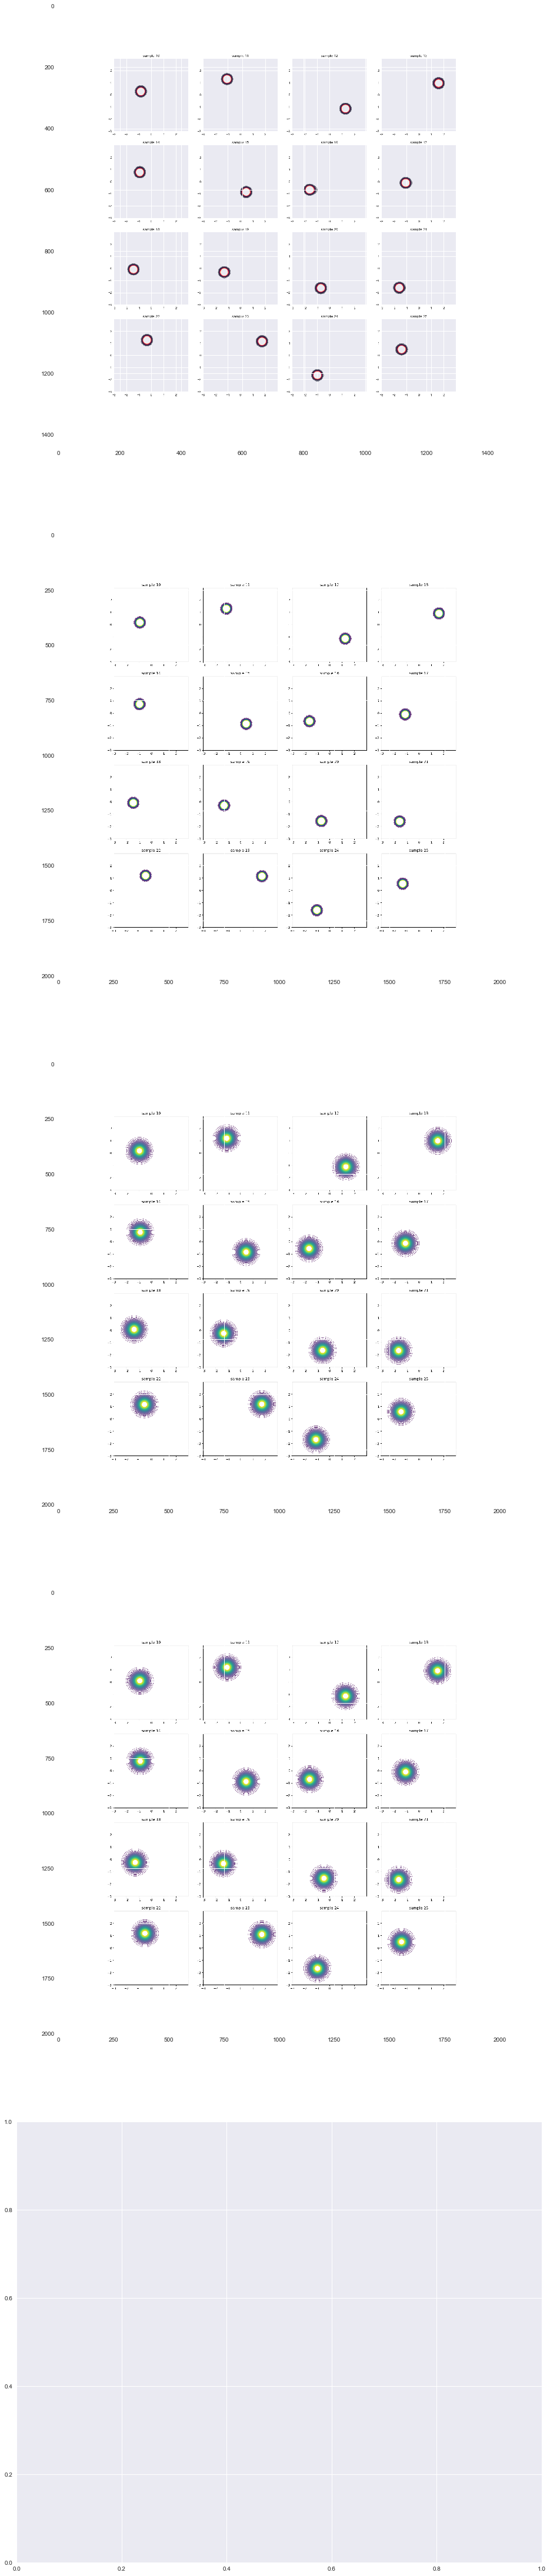

In [37]:
RMSE = []
PCC = []
picnums = 5
fig,ax=plt.subplots(picnums,figsize=(16,16*picnums))
count =0
for i in os.listdir(load_path):
    try:
        RMSE.append(np.loadtxt(load_path+i+'/RMSE_PCC.txt')[0])
        PCC.append(np.loadtxt(load_path+i+'/RMSE_PCC.txt')[1])
        if np.loadtxt(load_path+i+'/RMSE_PCC.txt')[1]>=0.5:
            print (i,np.loadtxt(load_path+i+'/RMSE_PCC.txt')[1])
            ax[count].imshow(imread(load_path+i+'/distribution.png'))
            count+=1
    except:
        print ('no such file')

(array([2., 1., 1., 3., 3., 1., 3., 1., 3., 3., 1., 7., 6., 7., 2., 2., 2.,
        3., 1., 1., 1., 3., 2., 0., 1., 1., 1., 1., 0., 0., 1., 0., 0., 2.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1.]),
 array([-0.087112  , -0.06623586, -0.04535972, -0.02448358, -0.00360744,
         0.0172687 ,  0.03814484,  0.05902098,  0.07989712,  0.10077326,
         0.1216494 ,  0.14252554,  0.16340168,  0.18427782,  0.20515396,
         0.2260301 ,  0.24690624,  0.26778238,  0.28865852,  0.30953466,
         0.3304108 ,  0.35128694,  0.37216308,  0.39303922,  0.41391536,
         0.4347915 ,  0.45566764,  0.47654378,  0.49741992,  0.51829606,
         0.5391722 ,  0.56004834,  0.58092448,  0.60180062,  0.62267676,
         0.6435529 ,  0.66442904,  0.68530518,  0.70618132,  0.72705746,
         0.7479336 ,  0.76880974,  0.78968588,  0.81056202,  0.83143816,
         0.8523143 ,  0.87319044,  0.89406658,  0.91494273,  0.93581887,
         0.95669501]),
 <a list of 50 Patch 

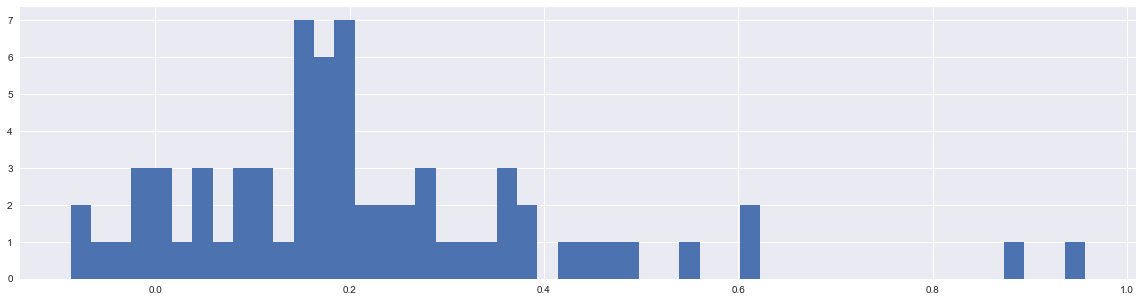

In [39]:
fig,ax=plt.subplots(1,figsize=(20,5))
ax.hist(PCC,bins=50)

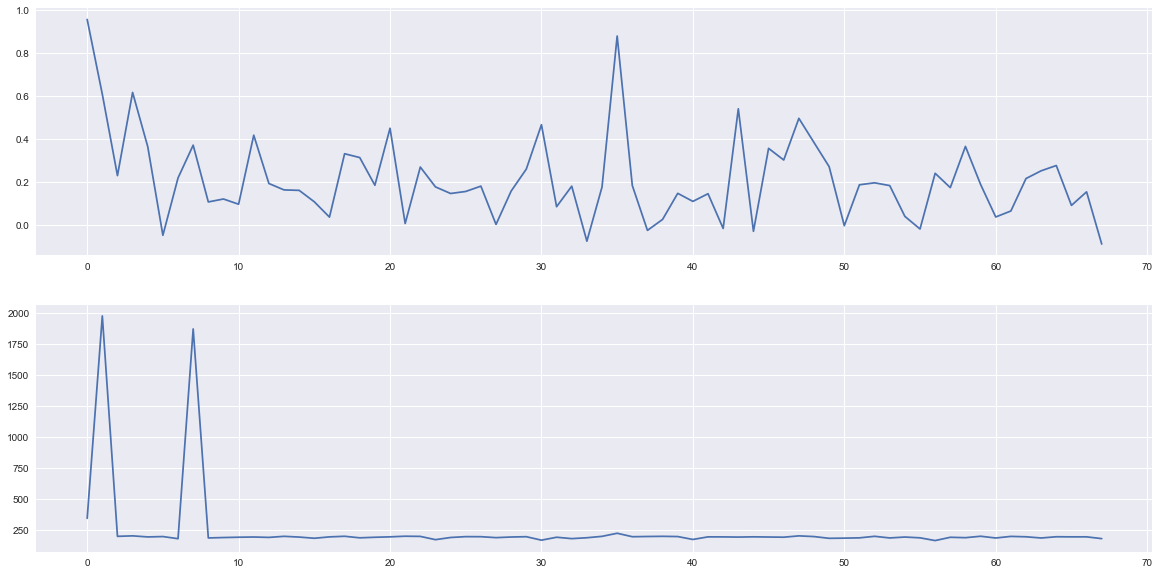

In [41]:
fig,ax=plt.subplots(2,1,figsize=(20,10))
ax[0].plot(PCC)
ax[1].plot(RMSE)

In [42]:
pearsonr(PCC,RMSE)  
#指所有PCC（每组参数所有样本的RMSE与pmodes的相反数的pcc）与所有RMSE的相关性
#相关性强说明模型预测的好的（RMSE低的），模型对样本预测难度的把握程度也高
#可以看看哪些参数下pcc(PCC,RMSE)高

(0.27922703764945633, 0.02111353823285822)

### move distribution pnd together

In [43]:
import shutil
import os
source = os.listdir("bestparas_new/")
destination = "bestparas_new_pic/"
for files in tqdm(source):
    try:
        pcctmpname = np.round(np.loadtxt('bestparas_new/'+files+'/RMSE_PCC.txt')[1],3)
        if os.path.isfile(destination+str(pcctmpname)+'_'+files+'_distribution.png'):
            print ('skip')
        else:
            shutil.copy('bestparas_new/'+files+'/distribution.png',destination)    
            os.rename(destination+'distribution.png',destination+str(pcctmpname)+'_'+files+'_distribution.png')
    except:
        print ('no such picture')

HBox(children=(IntProgress(value=0, max=69), HTML(value=u'')))

no such picture
skip
skip
skip
skip
skip
no such picture
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip



### 获得不同参数的预测的每个样本的RMSE，存起来

In [44]:
RMSE_sample = {}
pmodes_sample = {}
count =0
for i in os.listdir(load_path):
    try:
        RMSE_sample[count] = np.loadtxt(load_path+i+'/RMSE_sample.txt')
        pmodes_sample[count] = np.loadtxt(load_path+i+'/pmodes_sample.txt')
        count+=1
    except:
        print ('no such file')

no such file


In [45]:
rmse_sample = np.ndarray([len(RMSE_sample),250])
pmodes_sample = np.ndarray([len(pmodes_sample),250])
for i in range(len(RMSE_sample)):
    rmse_sample[i] = RMSE_sample[i]
    pmodes_sample[i] = pmodes_sample[i]

In [46]:
rmse_sample.shape

(68, 250)

##### 在所有RMSE小于200的前提下，测试每个样本很多次RMSE的boxplot和很多次pmodes的boxplot

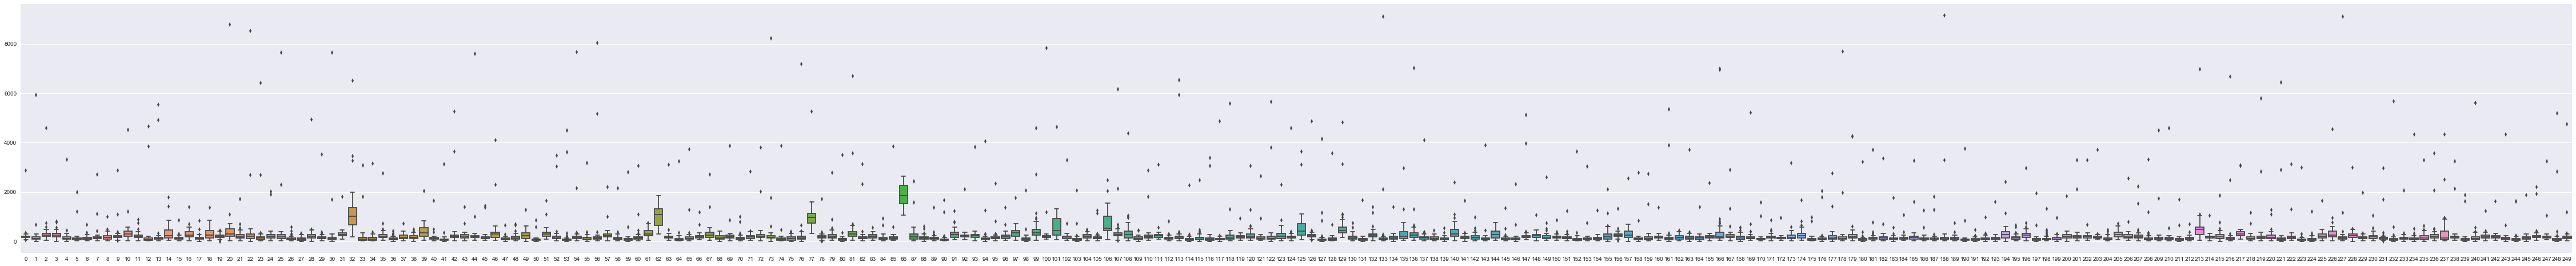

In [47]:
fig,ax=plt.subplots(1,figsize=(80,8))
sns.boxplot(data=pd.DataFrame(rmse_sample),ax=ax)
fig.savefig('plot/boxplot.png')

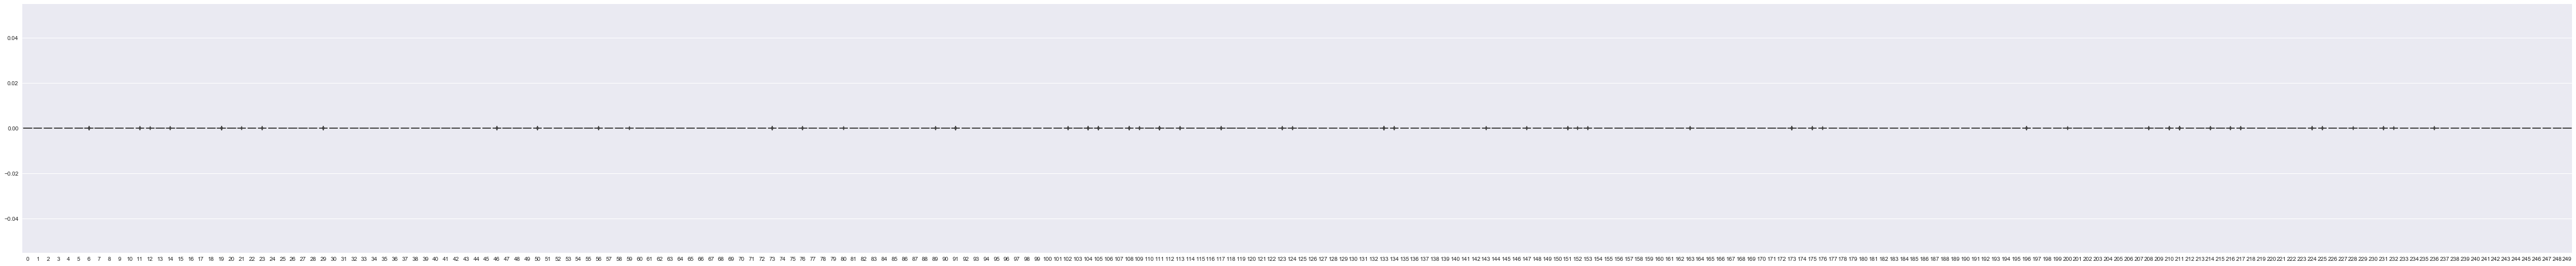

In [48]:
fig,ax=plt.subplots(1,figsize=(80,8))
sns.boxplot(data=pd.DataFrame(pmodes_sample),ax=ax)

In [49]:
pmodes_sample.ravel()

array([2.00271247e-307, 8.90130551e-308, 1.37961573e-306, ...,
       1.05701194e-307, 1.20161797e-306, 9.34588740e-307])

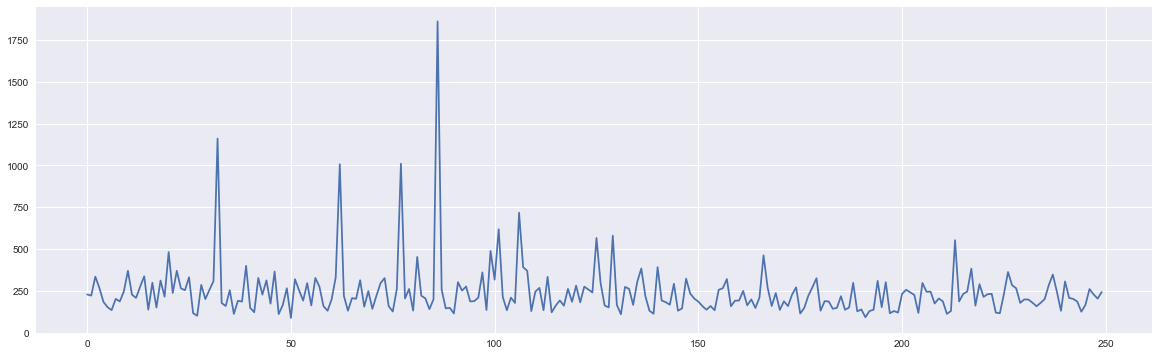

In [50]:
fig,ax=plt.subplots(1,figsize=(20,6))
ax.plot(np.average(rmse_sample,axis=0))

In [51]:
np.average(rmse_sample,axis=0)[np.argsort(np.average(rmse_sample,axis=0))[-10:]]

array([ 489.8989922 ,  554.23559901,  567.43444922,  581.38361128,
        619.42747155,  718.15328142, 1007.31087068, 1010.08938542,
       1160.52233236, 1859.42722276])

In [52]:
np.average(rmse_sample,axis=1).shape

(68,)

- 找出来一直不好的样本，去掉，重新算RMSE
#### 证明对于RMSE比较好的结果中，去掉比较差的几个样本，通常可以获得20左右的RMSE的提升

In [53]:
np.average(rmse_sample,axis=1) - np.average(np.delete(rmse_sample,np.argsort(np.average(rmse_sample,axis=0))[-10:],axis=1),axis=1)

array([52.0257571 , 26.41635246, 29.22565978, 25.0666747 , 23.37297507,
       16.16646707, 28.16899917, 50.475627  , 19.092736  , 23.0678908 ,
       25.97918836, 20.7126588 , 25.72273741, 25.01571307, 19.30476856,
       21.67986325, 20.81711413, 28.00004835, 22.45131546, 22.84371322,
       27.54626105, 30.5285689 , 34.57764381, 26.76386102, 22.44649992,
       25.96942053, 25.42733594, 22.12498944, 24.47971987, 25.25592919,
       19.70377913, 21.01625567, 24.44301162, 29.63833616, 24.77479472,
       22.07976232, 27.23551337, 27.68104184, 26.8464256 , 21.28579419,
       21.33283925, 21.99294305, 22.78274614, 28.72554928, 22.69790815,
       21.17255242, 24.05227858, 20.62018205, 27.72409579, 22.39802923,
       25.12445517, 24.21820567, 35.89261767, 26.32079646, 25.53462925,
       25.4895738 , 26.93456826, 24.5804005 , 26.30600028, 23.17839098,
       18.96231722, 23.40589915, 27.13594706, 27.01347759, 26.75652497,
       27.14102234, 25.10523923, 25.22425824])

##### 在所有RMSE小于200的前提下且PCC大于0.8，测试每个样本很多次RMSE的boxplot和很多次pmodes的boxplot

- 在比较好的p_modes和RMSE的pcc中，是否能一致地通过pmodes发现这些用RMSE定义出来的差样本？

#后续如何确定R也是个问题，如何知道要找多大范围的R呢，对于不同过得分布R如何公平？
R =2
def get_circle(R=0.05,center=[m,n],scale=0.001):
    #分别产生x和y的方阵，算每个点的距圆心距离，只要符合要求的# R is the radius

### 后续思路
- [x] 改成zscore
- [x] pi加限制，加pseudocount 基本解决nan问题

- 研究各个参数
- 大规模测试参数： RMSE作为衡量指标
    - 用哪些数据集
    - sigma 范围
    - Gaussian数量
    - MLP网络相关参数
        - layer
        - activation...
- 观察参数和结果的规律

- loss下降与结果好相关不强，极值点的pdf过小，总体太平均了
- 考虑研究数据本身的特征
- outlier：距离差大的是不是不确定度也大
    - 看看误差大的样本是不是不确定度也大，如果真的相关性强的话，那我们就找到了一个很好的方法来衡量样本的预测难度
- 借鉴bishop的一些绘图思路，可视化出来probablity
- 生成二维分布时是否可以考虑$\rho$
- 观察数据分布，分析
- 其他
- 可以画类似一维置信区间的二维置信区域图
- VAE
- 如果训练时候可以训练一段时间然后得到p modes筛除掉不可信样本再训练，结果是否可以提升   
- 能否指示不好预测的样本，能否指示应该用你哪些特征？
- 单独分析不好预测的样本？有没有哪些样本在很多模型都不好预测？
- RMSE不高但是其他条件好的样本也值得考虑，也许可以挑出来不好的样本，重新训练等，能够找样本很重要
- 另外我想看一下对于那些RMSE和pmodes相关性强的组合，如果可以把预测不好的样本找出来，后续我们可以用什么办法把这些样本预测好，当然也可以单独分析一下这些样本为什么有问题